In [ ]:
import time
import os
import copy


import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms

import pandas as pd
import matplotlib.pyplot as plt
import cv2

import shutil, os

!pip install split-folders
import splitfolders

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d sovitrath/diabetic-retinopathy-224x224-2019-data

In [ ]:
import zipfile
def unzip(filename):
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

import os

In [ ]:
unzip("/content/diabetic-retinopathy-224x224-2019-data.zip")

In [ ]:
origin = "/content/colored_images/"

os.mkdir('/content/Datasets')
os.mkdir('/content/Datasets/NO_DR')
os.mkdir('/content/Datasets/DR')

target = "/content/Datasets/DR/"

In [ ]:
files = os.listdir(origin+"/Mild/")

for file_name in files:
   shutil.copy(origin+"/Mild/"+file_name, target)

files = os.listdir(origin+"/Moderate/")


for file_name in files:
   shutil.copy(origin+"/Moderate/"+file_name, target)

files = os.listdir(origin+"/Proliferate_DR/")


for file_name in files:
   shutil.copy(origin+"/Proliferate_DR/"+file_name, target)

files = os.listdir(origin+"/Severe/")


for file_name in files:
   shutil.copy(origin+"/Severe/"+file_name, target)


target = "/content/Datasets/NO_DR/"
files = os.listdir(origin+"/No_DR/")

for file_name in files:
   shutil.copy(origin+"/No_DR/"+file_name, target)


In [ ]:
import os

def walk_through_dir(dir_path):

  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


walk_through_dir("/content/Datasets")

There are 2 directories and 0 images in '/content/Datasets'.
There are 0 directories and 1805 images in '/content/Datasets/NO_DR'.
There are 0 directories and 1857 images in '/content/Datasets/DR'.


In [ ]:
splitfolders.ratio('/content/Datasets', output='/content/Datasets_Split',
                   seed=42, ratio=(.8, .2), group_prefix=None)

Copying files: 3662 files [00:00, 4263.46 files/s]


In [ ]:
walk_through_dir('/content/Datasets_Split')

There are 2 directories and 0 images in '/content/Datasets_Split'.
There are 2 directories and 0 images in '/content/Datasets_Split/val'.
There are 0 directories and 361 images in '/content/Datasets_Split/val/NO_DR'.
There are 0 directories and 372 images in '/content/Datasets_Split/val/DR'.
There are 2 directories and 0 images in '/content/Datasets_Split/train'.
There are 0 directories and 1444 images in '/content/Datasets_Split/train/NO_DR'.
There are 0 directories and 1485 images in '/content/Datasets_Split/train/DR'.


In [ ]:
os.rename('/content/Datasets_Split/val', '/content/Datasets_Split/test')

In [ ]:
train_loc = '/content/Datasets_Split/train'
test_loc = '/content/Datasets_Split/test'

## Preprocessing and viewing the preprocessed data

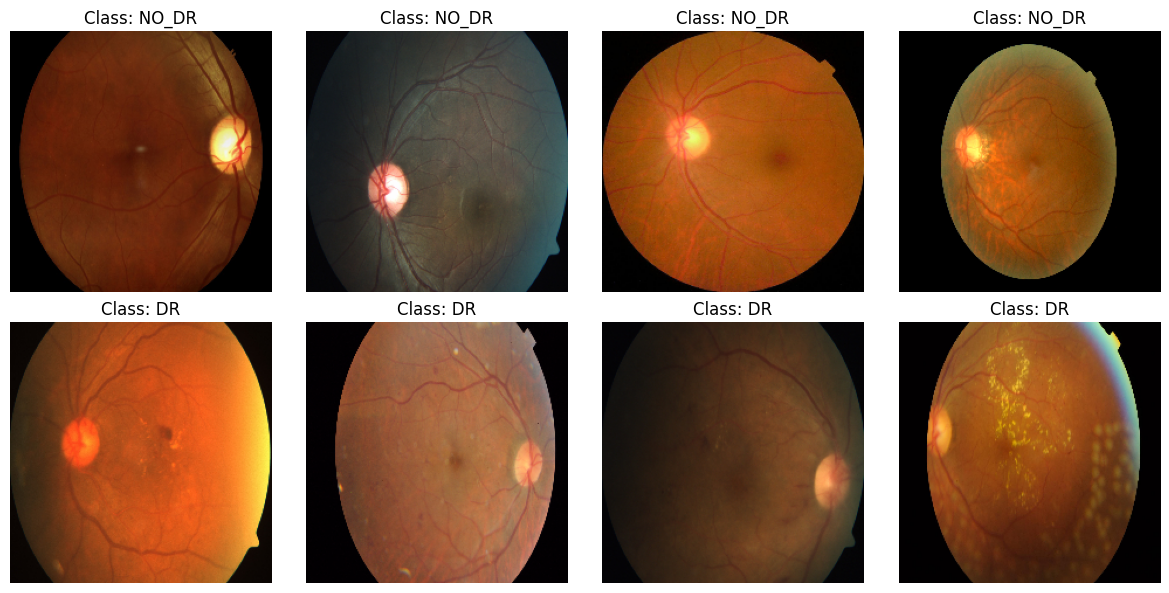

In [ ]:
from PIL import Image

class_names = os.listdir(train_loc)
num_images = 4  # Images per class

plt.figure(figsize=(12, 6))

i = 1
for class_name in class_names:
    class_path = os.path.join(train_loc, class_name)
    images = os.listdir(class_path)[:num_images]  # Get first few images

    for img_name in images:
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        plt.subplot(len(class_names), num_images, i)
        plt.imshow(img)
        plt.title(f"Class: {class_name}")
        plt.axis('off')
        i += 1

plt.tight_layout()
plt.show()

Found 2929 images belonging to 2 classes.
Found 733 images belonging to 2 classes.


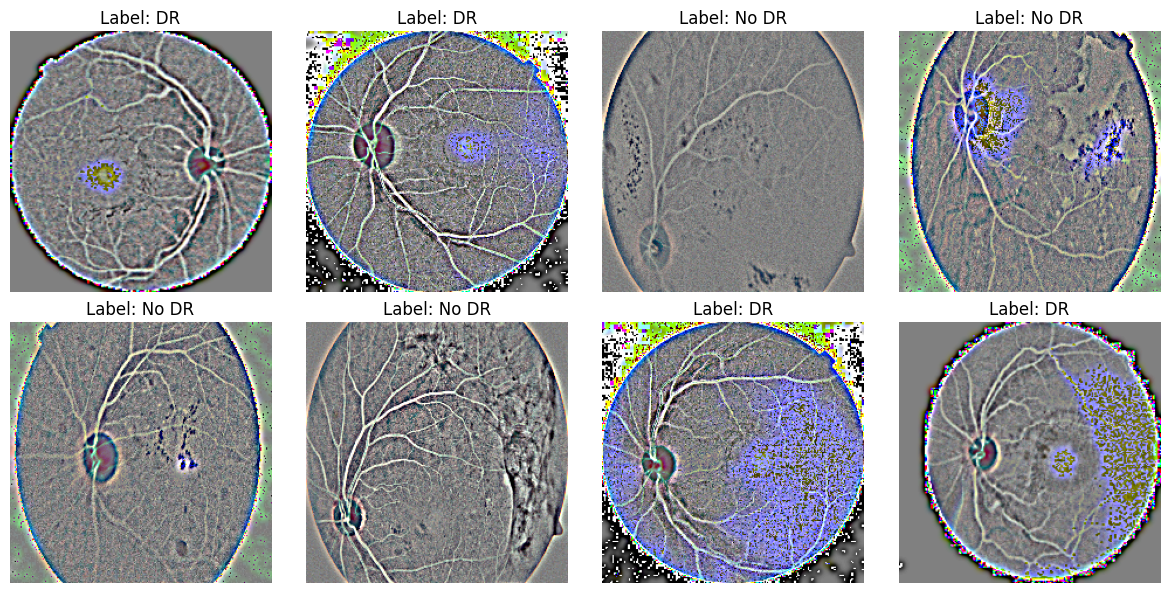

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


def preprocess_image(img):
    # Convert to uint8
    img = (img * 255).astype(np.uint8)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)[1]
    x, y, w, h = cv2.boundingRect(mask)
    img = img[y:y+h, x:x+w]

    img = cv2.resize(img, (224, 224))

    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    merged = cv2.merge((cl, a, b))
    img = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)


    blur = cv2.GaussianBlur(img, (15, 15), 0)
    img = cv2.addWeighted(img, 4, blur, -4, 128)

    img = img / 255.0

    return img

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rescale=None,
    rotation_range=0,
    zoom_range=0,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rescale=None
)

train_dir = "/content/Datasets_Split/train"
test_dir = "/content/Datasets_Split/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

import matplotlib.pyplot as plt

images, labels = next(train_data)

plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {'DR' if labels[i]==1 else 'No DR'}")
    plt.axis('off')
plt.tight_layout()
plt.show()


###### The fewer layers that are trainable, the less the model adapts to your data

# VGG 16

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

VGGmodel = Model(inputs=base_model.input, outputs=output)


VGGmodel.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=BinaryCrossentropy(),
    metrics=['accuracy']
)

VGGmodel.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "vgg16_binary_dr_model.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

early = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)



In [ ]:
VGGhistory = VGGmodel.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    callbacks=[checkpoint, early]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8637 - loss: 0.2954
Epoch 1: val_accuracy improved from -inf to 0.96044, saving model to vgg16_binary_dr_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 65s 555ms/step - accuracy: 0.8643 - loss: 0.2945 - val_accuracy: 0.9604 - val_loss: 0.1306
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9517 - loss: 0.1605
Epoch 2: val_accuracy did not improve from 0.96044
92/92 ━━━━━━━━━━━━━━━━━━━━ 42s 260ms/step - accuracy: 0.9517 - loss: 0.1605 - val_accuracy: 0.9550 - val_loss: 0.1518
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.9501 - loss: 0.1409
Epoch 3: val_accuracy improved from 0.96044 to 0.96317, saving model to vgg16_binary_dr_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 272ms/step - accuracy: 0.9501 - loss: 0.1409 - val_accuracy: 0.9632 - val_loss: 0.1194
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9507 - loss: 0.1378
Epoch 4: val_accuracy did not improve from 0.96317
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 272ms/step - accuracy: 0.9507 - loss: 0.1377 - val_accuracy: 0.9618 - val_loss: 0.1193
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9656 - loss: 0.1080
Epoch 5: val_accuracy did not improve from 0.96317
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 263ms/step - accuracy: 0.9655 - loss: 0.1082 - val_accuracy: 0.9591 - val_loss: 0.1274
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9539 - loss: 0.1177
Epoch 6: val_accuracy improved from 0.96317 to 0.96726, saving model to vgg16_binary_dr_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 281ms/step - accuracy: 0.9539 - loss: 0.1176 - val_accuracy: 0.9673 - val_loss: 0.1132
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.9499 - loss: 0.1282
Epoch 7: val_accuracy did not improve from 0.96726
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 261ms/step - accuracy: 0.9499 - loss: 0.1280 - val_accuracy: 0.9632 - val_loss: 0.1153
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.9650 - loss: 0.0934
Epoch 8: val_accuracy did not improve from 0.96726
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 268ms/step - accuracy: 0.9649 - loss: 0.0934 - val_accuracy: 0.9591 - val_loss: 0.1102
Epoch 9/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9641 - loss: 0.1015
Epoch 9: val_accuracy did not improve from 0.96726
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 260ms/step - accuracy: 0.9641 - loss: 0.1014 - val_accuracy: 0.9645 - val_loss: 0.1182
Epoch 10/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9651 - loss: 0.0887
Epoch 10: val_accuracy did not

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


y_pred = VGGmodel.predict(test_data)


y_pred_classes = np.round(y_pred).astype(int).reshape(-1)


y_true = test_data.classes


print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=['No DR', 'DR']))


print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred_classes))


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step
Classification Report:

              precision    recall  f1-score   support

       No DR       0.99      0.94      0.97       372
          DR       0.94      0.99      0.97       361

    accuracy                           0.97       733
   macro avg       0.97      0.97      0.97       733
weighted avg       0.97      0.97      0.97       733

Confusion Matrix:

[[351  21]
 [  3 358]]


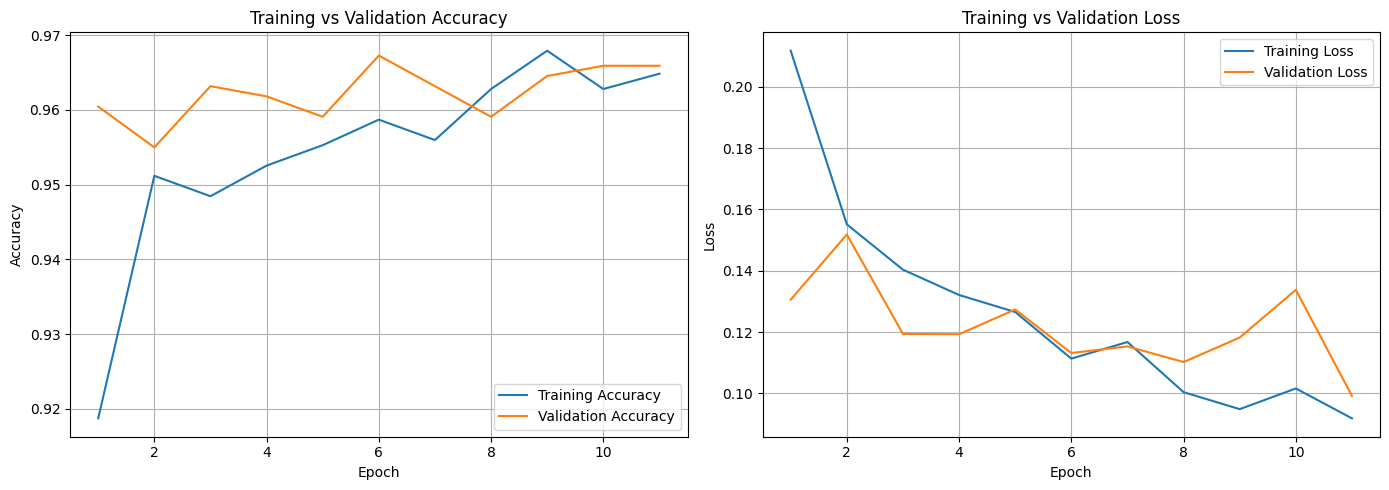

In [ ]:
import matplotlib.pyplot as plt

acc = VGGhistory.history['accuracy']
val_acc = VGGhistory.history['val_accuracy']
loss = VGGhistory.history['loss']
val_loss = VGGhistory.history['val_loss']

epochs_range = range(1, len(acc) + 1)


plt.figure(figsize=(14, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


# ResNet 50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

resmodel = Model(inputs=base_model.input, outputs=output)
resmodel.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
checkpoint = ModelCheckpoint(
    "resnet50_binary_dr_model.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto'
)


In [ ]:
reshistory = resmodel.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    callbacks=[checkpoint, early]
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.5457 - loss: 0.7474
Epoch 1: val_accuracy improved from -inf to 0.75853, saving model to resnet50_binary_dr_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 50s 399ms/step - accuracy: 0.5461 - loss: 0.7468 - val_accuracy: 0.7585 - val_loss: 0.5594
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.6628 - loss: 0.6036
Epoch 2: val_accuracy improved from 0.75853 to 0.81855, saving model to resnet50_binary_dr_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 259ms/step - accuracy: 0.6632 - loss: 0.6033 - val_accuracy: 0.8186 - val_loss: 0.4968
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.7658 - loss: 0.5185
Epoch 3: val_accuracy improved from 0.81855 to 0.82947, saving model to resnet50_binary_dr_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 247ms/step - accuracy: 0.7660 - loss: 0.5183 - val_accuracy: 0.8295 - val_loss: 0.4526
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.7978 - loss: 0.4727
Epoch 4: val_accuracy improved from 0.82947 to 0.84311, saving model to resnet50_binary_dr_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 246ms/step - accuracy: 0.7979 - loss: 0.4725 - val_accuracy: 0.8431 - val_loss: 0.4339
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.8278 - loss: 0.4312
Epoch 5: val_accuracy improved from 0.84311 to 0.85812, saving model to resnet50_binary_dr_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 239ms/step - accuracy: 0.8279 - loss: 0.4311 - val_accuracy: 0.8581 - val_loss: 0.3933
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.8562 - loss: 0.3871
Epoch 6: val_accuracy improved from 0.85812 to 0.86903, saving model to resnet50_binary_dr_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 257ms/step - accuracy: 0.8561 - loss: 0.3872 - val_accuracy: 0.8690 - val_loss: 0.3727
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8567 - loss: 0.3799
Epoch 7: val_accuracy improved from 0.86903 to 0.87585, saving model to resnet50_binary_dr_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 248ms/step - accuracy: 0.8568 - loss: 0.3798 - val_accuracy: 0.8759 - val_loss: 0.3542
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8742 - loss: 0.3550
Epoch 8: val_accuracy improved from 0.87585 to 0.87995, saving model to resnet50_binary_dr_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 248ms/step - accuracy: 0.8742 - loss: 0.3550 - val_accuracy: 0.8799 - val_loss: 0.3397
Epoch 9/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8679 - loss: 0.3485
Epoch 9: val_accuracy did not improve from 0.87995
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 245ms/step - accuracy: 0.8679 - loss: 0.3485 - val_accuracy: 0.8786 - val_loss: 0.3287
Epoch 10/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.8806 - loss: 0.3178
Epoch 10: val_accuracy improved from 0.87995 to 0.88267, saving model to resnet50_binary_dr_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 248ms/step - accuracy: 0.8805 - loss: 0.3179 - val_accuracy: 0.8827 - val_loss: 0.3212
Epoch 11/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.8761 - loss: 0.3269
Epoch 11: val_accuracy improved from 0.88267 to 0.88404, saving model to resnet50_binary_dr_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 255ms/step - accuracy: 0.8762 - loss: 0.3268 - val_accuracy: 0.8840 - val_loss: 0.3076
Epoch 12/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8810 - loss: 0.3103
Epoch 12: val_accuracy improved from 0.88404 to 0.88950, saving model to resnet50_binary_dr_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 250ms/step - accuracy: 0.8811 - loss: 0.3102 - val_accuracy: 0.8895 - val_loss: 0.3053
Epoch 13/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.8919 - loss: 0.3018
Epoch 13: val_accuracy did not improve from 0.88950
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 247ms/step - accuracy: 0.8919 - loss: 0.3018 - val_accuracy: 0.8881 - val_loss: 0.2944
Epoch 14/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.8859 - loss: 0.2931
Epoch 14: val_accuracy improved from 0.88950 to 0.89359, saving model to resnet50_binary_dr_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - accuracy: 0.8859 - loss: 0.2931 - val_accuracy: 0.8936 - val_loss: 0.2909
Epoch 15/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.8822 - loss: 0.2998
Epoch 15: val_accuracy improved from 0.89359 to 0.89495, saving model to resnet50_binary_dr_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 256ms/step - accuracy: 0.8822 - loss: 0.2997 - val_accuracy: 0.8950 - val_loss: 0.2932
Epoch 16/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8812 - loss: 0.2940
Epoch 16: val_accuracy improved from 0.89495 to 0.89768, saving model to resnet50_binary_dr_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 258ms/step - accuracy: 0.8812 - loss: 0.2939 - val_accuracy: 0.8977 - val_loss: 0.2783
Epoch 17/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.8986 - loss: 0.2685
Epoch 17: val_accuracy did not improve from 0.89768
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 243ms/step - accuracy: 0.8986 - loss: 0.2685 - val_accuracy: 0.8977 - val_loss: 0.2732
Epoch 18/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9014 - loss: 0.2709
Epoch 18: val_accuracy improved from 0.89768 to 0.90041, saving model to resnet50_binary_dr_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 262ms/step - accuracy: 0.9014 - loss: 0.2709 - val_accuracy: 0.9004 - val_loss: 0.2698
Epoch 19/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.9126 - loss: 0.2525
Epoch 19: val_accuracy improved from 0.90041 to 0.90177, saving model to resnet50_binary_dr_model.h5


92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 252ms/step - accuracy: 0.9124 - loss: 0.2527 - val_accuracy: 0.9018 - val_loss: 0.2778
Epoch 20/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8881 - loss: 0.2718
Epoch 20: val_accuracy did not improve from 0.90177
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 242ms/step - accuracy: 0.8882 - loss: 0.2718 - val_accuracy: 0.9018 - val_loss: 0.2637
Restoring model weights from the end of the best epoch: 19.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_pred = resmodel.predict(test_data)

y_pred_classes = np.round(y_pred).astype(int).reshape(-1)

y_true = test_data.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=['No DR', 'DR']))

print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred_classes))


23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 361ms/step
Classification Report:

              precision    recall  f1-score   support

       No DR       0.93      0.87      0.90       372
          DR       0.88      0.93      0.90       361

    accuracy                           0.90       733
   macro avg       0.90      0.90      0.90       733
weighted avg       0.90      0.90      0.90       733

Confusion Matrix:

[[324  48]
 [ 24 337]]


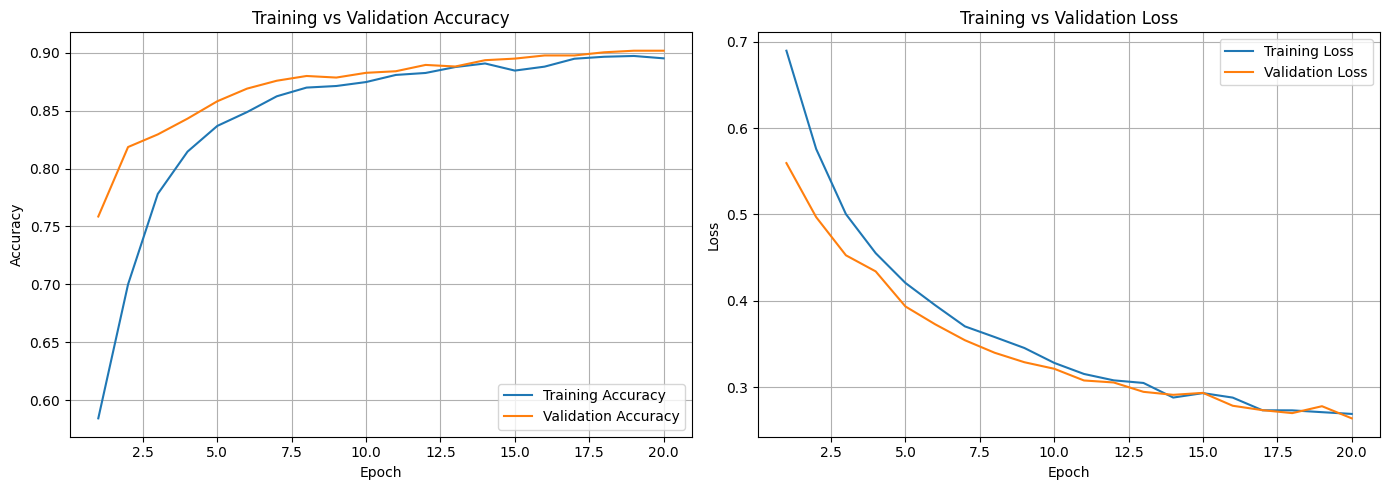

In [ ]:
acc = reshistory.history['accuracy']
val_acc = reshistory.history['val_accuracy']
loss = reshistory.history['loss']
val_loss = reshistory.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()


# InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

incmodel = Model(inputs=base_model.input, outputs=predictions)

incmodel.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

checkpoint = ModelCheckpoint("inceptionv3_binary_dr_model.keras", monitor='val_accuracy', save_best_only=True)
early = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

inchistory = incmodel.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    callbacks=[checkpoint, early]
)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 62s 484ms/step - accuracy: 0.6465 - loss: 0.6633 - val_accuracy: 0.9045 - val_loss: 0.3222
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 258ms/step - accuracy: 0.8265 - loss: 0.4052 - val_accuracy: 0.9222 - val_loss: 0.2579
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 252ms/step - accuracy: 0.8731 - loss: 0.3183 - val_accuracy: 0.9291 - val_loss: 0.2304
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 262ms/step - accuracy: 0.8876 - loss: 0.2999 - val_accuracy: 0.9332 - val_loss: 0.2123
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 259ms/step - accuracy: 0.9053 - loss: 0.2457 - val_accuracy: 0.9372 - val_loss: 0.2024
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 236ms/step - accuracy: 0.8991 - loss: 0.2649 - val_accuracy: 0.9372 - val_loss: 0.1946
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 243ms/step - accuracy: 0.9128 - loss: 0.2404 - val_accuracy: 0.9304 - val_loss: 0.1974
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 262m

In [ ]:
y_pred = incmodel.predict(test_data)

y_pred_classes = np.round(y_pred).astype(int).reshape(-1)

y_true = test_data.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=['No DR', 'DR']))

print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred_classes))

23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 455ms/step
Classification Report:

              precision    recall  f1-score   support

       No DR       0.97      0.94      0.96       372
          DR       0.94      0.97      0.95       361

    accuracy                           0.95       733
   macro avg       0.96      0.96      0.95       733
weighted avg       0.96      0.95      0.95       733

Confusion Matrix:

[[351  21]
 [ 12 349]]


In [ ]:
y_pred = incmodel.predict(test_data)

y_pred_classes = np.round(y_pred).astype(int).reshape(-1)

y_true = test_data.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=['No DR', 'DR']))

print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred_classes))

23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step
Classification Report:

              precision    recall  f1-score   support

       No DR       0.97      0.94      0.96       372
          DR       0.94      0.97      0.95       361

    accuracy                           0.95       733
   macro avg       0.96      0.96      0.95       733
weighted avg       0.96      0.95      0.95       733

Confusion Matrix:

[[351  21]
 [ 12 349]]


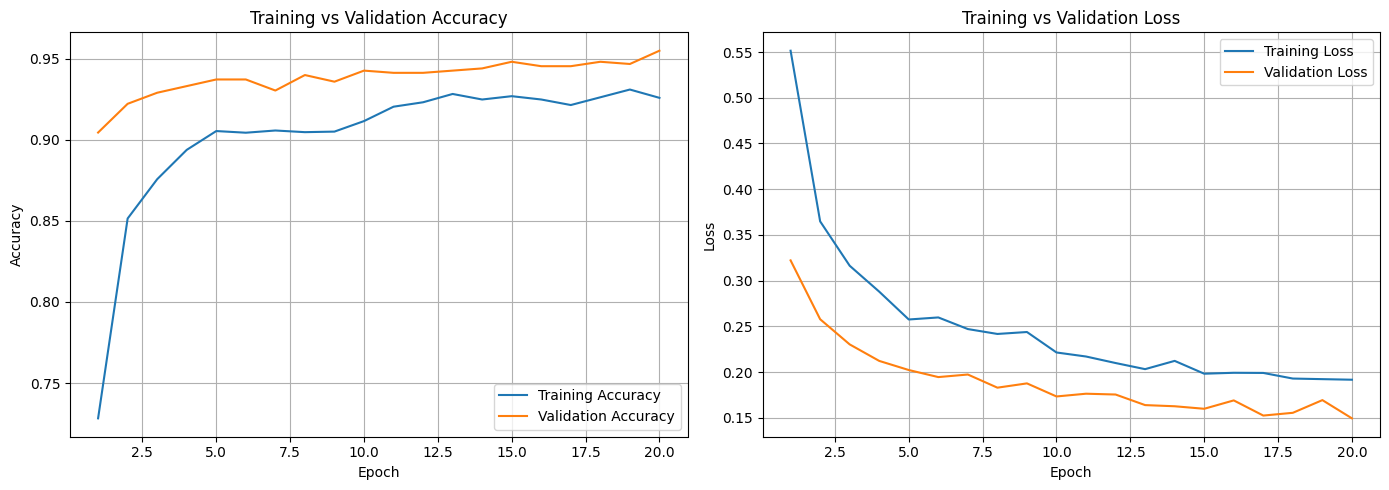

In [ ]:
acc = inchistory.history['accuracy']
val_acc = inchistory.history['val_accuracy']
loss = inchistory.history['loss']
val_loss = inchistory.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# EfficientNet

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze last 30 layers
for layer in base_model.layers[-30:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation='sigmoid')(x)

eff_model = Model(inputs=base_model.input, outputs=predictions)

eff_model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

checkpoint = ModelCheckpoint("efficientnetb0_binary_dr_model.keras", monitor='val_accuracy', save_best_only=True)
early = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

eff_history = eff_model.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    callbacks=[checkpoint, early]
)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 155s 826ms/step - accuracy: 0.8109 - loss: 0.4348 - val_accuracy: 0.4925 - val_loss: 0.6944
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 274ms/step - accuracy: 0.9456 - loss: 0.1584 - val_accuracy: 0.5362 - val_loss: 0.6895
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 264ms/step - accuracy: 0.9575 - loss: 0.1154 - val_accuracy: 0.5102 - val_loss: 0.6588
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 275ms/step - accuracy: 0.9665 - loss: 0.0935 - val_accuracy: 0.6003 - val_loss: 0.6120
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 275ms/step - accuracy: 0.9732 - loss: 0.0625 - val_accuracy: 0.7435 - val_loss: 0.5171
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 270ms/step - accuracy: 0.9680 - loss: 0.0805 - val_accuracy: 0.8527 - val_loss: 0.3710
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 252ms/step - accuracy: 0.9815 - loss: 0.0474 - val_accuracy: 0.8390 - val_loss: 0.4183
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 256

In [ ]:
y_pred = eff_model.predict(test_data)

y_pred_classes = np.round(y_pred).astype(int).reshape(-1)

y_true = test_data.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=['No DR', 'DR']))

print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred_classes))

23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 466ms/step
Classification Report:

              precision    recall  f1-score   support

       No DR       0.97      0.93      0.95       372
          DR       0.93      0.97      0.95       361

    accuracy                           0.95       733
   macro avg       0.95      0.95      0.95       733
weighted avg       0.95      0.95      0.95       733

Confusion Matrix:

[[346  26]
 [ 12 349]]


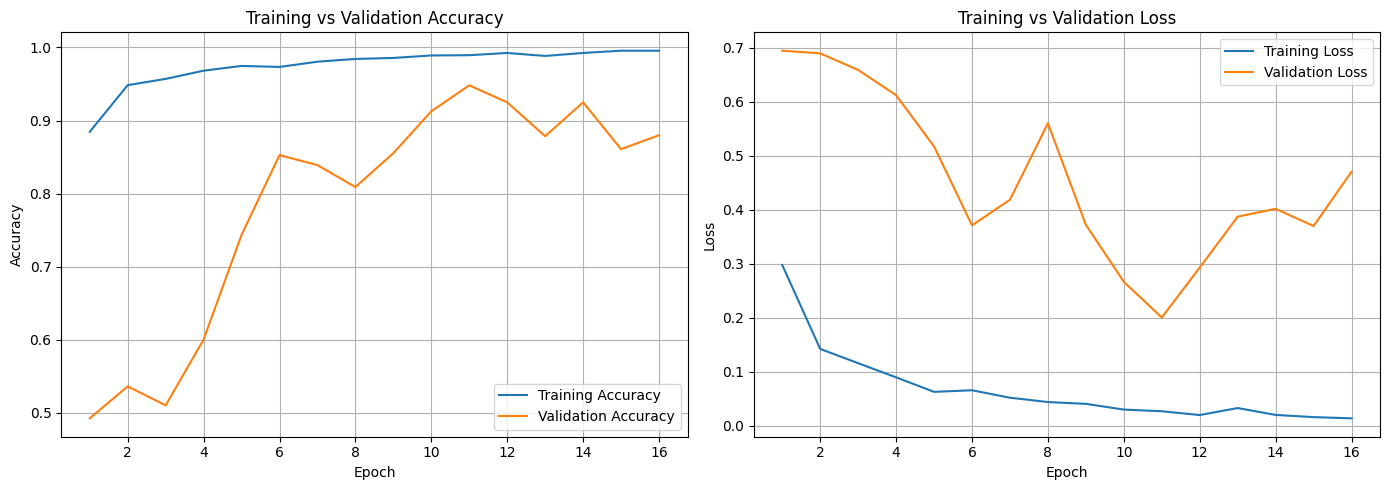

In [ ]:
acc = eff_history.history['accuracy']
val_acc = eff_history.history['val_accuracy']
loss = eff_history.history['loss']
val_loss = eff_history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Mobilenet V2

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=output)

mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

checkpoint = ModelCheckpoint("mobilenetv2_binary_dr_model.keras", monitor='val_accuracy', save_best_only=True)
early = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

mobilenet_history = mobilenet_model.fit(
    train_data,
    validation_data=test_data,
    epochs=20,
    callbacks=[checkpoint, early]
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 360ms/step - accuracy: 0.6232 - loss: 0.7246 - val_accuracy: 0.9181 - val_loss: 0.2569
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 239ms/step - accuracy: 0.8526 - loss: 0.3568 - val_accuracy: 0.9332 - val_loss: 0.1992
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 251ms/step - accuracy: 0.8972 - loss: 0.2779 - val_accuracy: 0.9318 - val_loss: 0.1803
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 255ms/step - accuracy: 0.9020 - loss: 0.2674 - val_accuracy: 0.9413 - val_loss: 0.1651
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 245ms/step - accuracy: 0.9109 - loss: 0.2567 - val_accuracy: 0.9359 - val_loss: 0.1617
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 248ms/step - accuracy: 0.9261 - loss: 0.2141 - val_accuracy: 0.9495 - val_loss: 0.1500
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 236ms/step - accuracy: 0.9349 - loss: 0.1985 - val_accuracy: 0.9495 - val_loss: 0.1486
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 23s 246ms/

In [ ]:
y_pred = mobilenet_model.predict(test_data)

y_pred_classes = np.round(y_pred).astype(int).reshape(-1)

y_true = test_data.classes

print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=['No DR', 'DR']))

print("Confusion Matrix:\n")
print(confusion_matrix(y_true, y_pred_classes))

23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 320ms/step
Classification Report:

              precision    recall  f1-score   support

       No DR       0.96      0.94      0.95       372
          DR       0.94      0.96      0.95       361

    accuracy                           0.95       733
   macro avg       0.95      0.95      0.95       733
weighted avg       0.95      0.95      0.95       733

Confusion Matrix:

[[350  22]
 [ 15 346]]


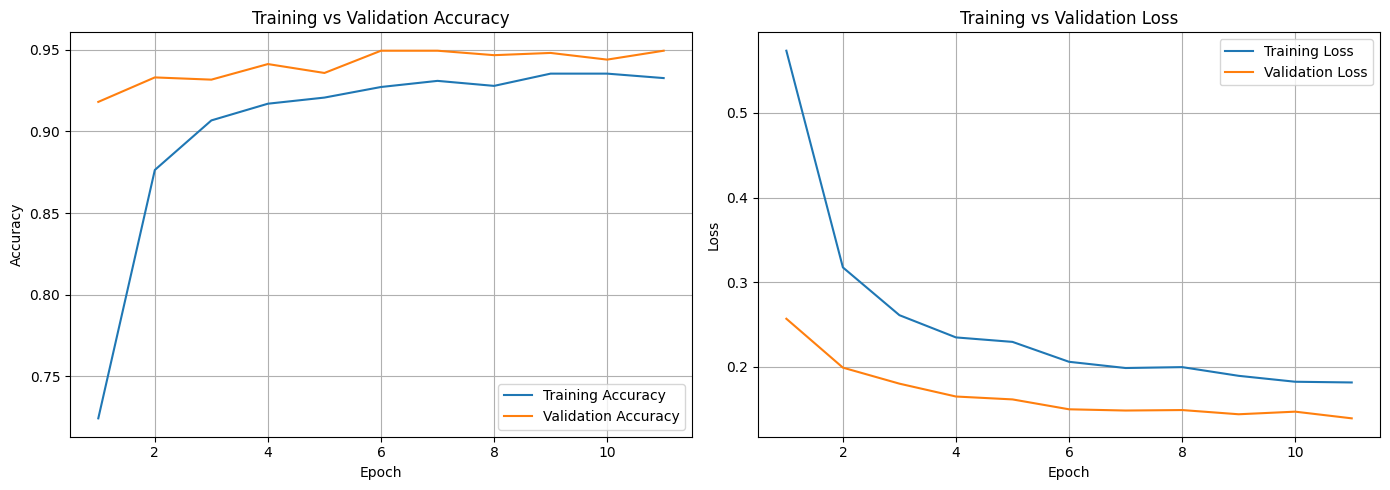

In [ ]:
acc = mobilenet_history.history['accuracy']
val_acc = mobilenet_history.history['val_accuracy']
loss = mobilenet_history.history['loss']
val_loss = mobilenet_history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

## Heavy preprocessing involved